In [42]:
import boto3
import statistics
from matplotlib import pyplot as plt

In [44]:
def get_tfjob_ids(client):
    tfjob_ids = set()
    client = boto3.client('s3', endpoint_url='https://s3.cern.ch')
    for key in client.list_objects(Bucket='dejan')['Contents']:
        if 'tfjob-id' in key['Key'] and '12-09' in key['Key']:
            object_name = key['Key']
            tf_job_id = object_name[9:45]
            tfjob_ids.add(tf_job_id)
            #lines = obj['Body'].read().decode()
            
    return tfjob_ids

def get_epochs_for_tfjob(tfjob_name):
    tfjob_epoch_objects = set()
    client = boto3.client('s3', endpoint_url='https://s3.cern.ch')
    for key in client.list_objects(Bucket='dejan')['Contents']:
        if tfjob_name in key['Key']:
            object_name = key['Key']
            tfjob_epoch_objects.add(object_name)
            
    return tfjob_epoch_objects

def parse_epoch_file(epoch_filename):
    obj = client.get_object(Bucket='dejan', Key=epoch_filename)
    lines = obj['Body'].read().decode()
    lines_list = lines.split('\n')

    epoch_metrics = {}
    epoch_metrics['batch_times'] = []
    for item in lines_list:
        if item == '':
            continue
        
        split_item = item.split('=')
        metric_name = split_item[0]
        metric_value = split_item[1]
        
        if 'time-batch' in metric_name:
            epoch_metrics['batch_times'].append(metric_value)
        else:
            epoch_metrics[metric_name] = metric_value
    
    #batch_size = 124987 / len(epoch_metrics['batch_times'])
    return epoch_metrics

def define_tfjobs_info_manually():
    tfjobs_run_info = {}
    tfjobs_run_info['75170fe4-3c3d-43f3-a9f7-9f4d36dbb538'] = {} 
    tfjobs_run_info['75170fe4-3c3d-43f3-a9f7-9f4d36dbb538']['batch-size-per-replica'] = '96'
    tfjobs_run_info['75170fe4-3c3d-43f3-a9f7-9f4d36dbb538']['num_replicas_in_sync'] = '16'
    tfjobs_run_info['75170fe4-3c3d-43f3-a9f7-9f4d36dbb538']['n_workers'] = '2'

    tfjobs_run_info['cdbd72d7-5198-4d4d-b574-2b4e3c038a5a'] = {} 
    tfjobs_run_info['cdbd72d7-5198-4d4d-b574-2b4e3c038a5a']['batch-size-per-replica'] = '96'
    tfjobs_run_info['cdbd72d7-5198-4d4d-b574-2b4e3c038a5a']['num_replicas_in_sync'] = '4'
    tfjobs_run_info['cdbd72d7-5198-4d4d-b574-2b4e3c038a5a']['n_workers'] = '2'

    tfjobs_run_info['3c91f9a7-7e55-494a-89fd-b74291a3c3ee'] = {} 
    tfjobs_run_info['3c91f9a7-7e55-494a-89fd-b74291a3c3ee']['batch-size-per-replica'] = '96'
    tfjobs_run_info['3c91f9a7-7e55-494a-89fd-b74291a3c3ee']['num_replicas_in_sync'] = '2'
    tfjobs_run_info['3c91f9a7-7e55-494a-89fd-b74291a3c3ee']['n_workers'] = '2'

    tfjobs_run_info['906385ef-b761-4ba8-91b4-c7629358607a'] = {} 
    tfjobs_run_info['906385ef-b761-4ba8-91b4-c7629358607a']['batch-size-per-replica'] = '96'
    tfjobs_run_info['906385ef-b761-4ba8-91b4-c7629358607a']['num_replicas_in_sync'] = '8'
    tfjobs_run_info['906385ef-b761-4ba8-91b4-c7629358607a']['n_workers'] = '2'

    tfjobs_run_info['25d344a0-3d97-46be-84e0-059f4ca8e5dd'] = {} 
    tfjobs_run_info['25d344a0-3d97-46be-84e0-059f4ca8e5dd']['batch-size-per-replica'] = '96'
    tfjobs_run_info['25d344a0-3d97-46be-84e0-059f4ca8e5dd']['num_replicas_in_sync'] = '64'
    tfjobs_run_info['25d344a0-3d97-46be-84e0-059f4ca8e5dd']['n_workers'] = '8'

    #AUTOTUNE no
    tfjobs_run_info['8a10de0a-a3ba-439c-8ed6-ad41b895755a'] = {} 
    tfjobs_run_info['8a10de0a-a3ba-439c-8ed6-ad41b895755a']['batch-size-per-replica'] = '96'
    tfjobs_run_info['8a10de0a-a3ba-439c-8ed6-ad41b895755a']['num_replicas_in_sync'] = '32'
    tfjobs_run_info['8a10de0a-a3ba-439c-8ed6-ad41b895755a']['n_workers'] = '4'

    #AUTOTUNE yes
    tfjobs_run_info['27d48135-66f7-412a-9f58-07c093fba326'] = {} 
    tfjobs_run_info['27d48135-66f7-412a-9f58-07c093fba326']['batch-size-per-replica'] = '64'
    tfjobs_run_info['27d48135-66f7-412a-9f58-07c093fba326']['num_replicas_in_sync'] = '32'
    tfjobs_run_info['27d48135-66f7-412a-9f58-07c093fba326']['n_workers'] = '4'
    
    return tfjobs_run_info

def filter_by(tfjob_info, name, filter_value):
    res_dict = {}
    for tfjob_id, tfjob_value in tfjob_info.items():
        for key in tfjob_value.keys():
            if key == name and tfjob_value[key] == filter_value:
                res_dict[tfjob_id] = tfjob_value
    return res_dict

def parse_tfjob_epoch_metrics(tfjobs_run_info, tfjob_ids):
    for tfjob_id in tfjob_ids:
        if not tfjob_id in tfjobs_run_info:
            tfjobs_run_info[tfjob_id] = {}

        tfjob_epochs = get_epochs_for_tfjob(tfjob_id)
        tfjobs_run_info[tfjob_id]['epoch'] = {}
        for epoch_filename in tfjob_epochs:
            epoch_number = epoch_filename.split('epoch')[1].split('-')[1]
            epoch_metrics = parse_epoch_file(epoch_filename)
            
            if 'batch-size-per-replica' in epoch_metrics.keys():
                tfjobs_run_info[tfjob_id]['batch-size-per-replica'] = epoch_metrics['batch-size-per-replica']
            if 'num_replicas_in_sync' in epoch_metrics.keys():
                tfjobs_run_info[tfjob_id]['num_replicas_in_sync'] = epoch_metrics['num_replicas_in_sync']
            if 'n_workers' in epoch_metrics.keys():
                tfjobs_run_info[tfjob_id]['n_workers'] = epoch_metrics['n_workers']
            
            tfjobs_run_info[tfjob_id]['epoch'][epoch_number] = epoch_metrics
            
def get_metrics(tfjobs_run_info, metric_name):
    metrics = []
    for tfjob_id, tfjob_value in tfjobs_run_info.items():
        metrics_job = []
        for epoch_index in sorted(tfjob_value['epoch'].keys()):
            metrics_job.append(tfjob_value['epoch'][epoch_index][metric_name])
        metrics.append(metrics_job)
        
    return metrics

def get_metrics_for_job(tfjobs_run_info, tfjob_id, metric_name):
    metrics = []

    for epoch_index in sorted(tfjobs_run_info[tfjob_id]['epoch'].keys()):
        metrics.append(tfjobs_run_info[tfjob_id]['epoch'][epoch_index][metric_name])
        
    return metrics

def get_average_from_index(lst, from_index=0):
    float_list = []
    for el in lst:
        float_list.append(float(el))
    return statistics.mean(float_list[from_index:])

client = boto3.client('s3', endpoint_url='https://s3.cern.ch')
tfjobs_run_info = define_tfjobs_info_manually()
tfjob_ids = get_tfjob_ids(client)
parse_tfjob_epoch_metrics(tfjobs_run_info, tfjob_ids)
print(len(tfjobs_run_info.keys()))

batch_96_tfjobs = filter_by(tfjobs_run_info, 'batch-size-per-replica', '96')
print(len(batch_96_tfjobs.keys()))

train_times = get_metrics(batch_96_tfjobs, 'train-epoch-time')
test_times = get_metrics_for_job(batch_96_tfjobs, 'd27c7156-6ce7-41d0-85f9-688a463bc33f', 'test-epoch-time')
print(test_times)

average_train_times = []
for lst in train_times:
    average_train_times.append(get_average_from_index(lst, 1))
    
print()
print(get_average_from_index(test_times, 1))

8
7
['26.282368898391724', '1.1848857402801514', '1.1880724430084229', '1.169074535369873', '1.2181150913238525']

1.190036952495575


[1779.2695560455322, 898.9685888290405, 453.05215460062027, 154.31731516122818, 154.28539210557938, 145.37730532884598, 136.24190831184387]
[1779.2695560455322, 898.9685888290405, 453.05215460062027, 154.31731516122818, 154.28539210557938, 145.37730532884598, 136.24190831184387]


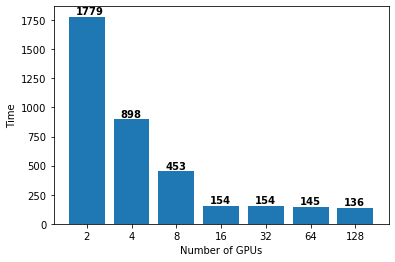

In [94]:
import numpy as np
print(average_train_times)
average_train_times = sorted(average_train_times, reverse=True)
print(average_train_times)
fig, ax = plt.subplots() 
plt.bar([1, 2, 3, 4, 5, 6, 7], average_train_times)
plt.yscale('linear')
plt.xticks(np.arange(1, 8), ('2', '4', '8', '16', '32', '64', '128'))
plt.ylabel('Time')
plt.xlabel('Number of GPUs')
for i, v in enumerate(average_train_times):
    ax.text(i + 0.75, v + 20,  str(int(v)), color='black', fontweight='bold')
plt.savefig('tfjob_first_plot.png', dpi=150)